### Making a pivot table

In [ ]:
import json
import pandas as pd
import numpy as np
import re

In [ ]:
# load the .json file into a data variable
file = open('data-sample.json')
data = json.load(file)

# make this data a pandas dataframe
df = pd.DataFrame(data)

In [ ]:
# lets first split the rows data of transaction_items into single item per row
# split rows
colSplit = 'transaction_items'

# split the column transaction_items with ';' semicolon as delimiter
newCol = df.assign(**{colSplit:df[colSplit].str.split(';')}) 


df = pd.DataFrame(
    {
        col:np.repeat(newCol[col].values, newCol[colSplit].str.len())
        for col in newCol.columns.difference([colSplit])
    }
    ).assign(**{colSplit:np.concatenate(newCol[colSplit].values)})[newCol.columns.tolist()]  

In [ ]:
# change the date in this dataframe to a dateTime instance
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

# now also get an extra column into the dataframe as month of transaction
df['month'] = df['transaction_date'].dt.month_name()

In [ ]:
# now we change the transaction_item into brand_name transaction_item and item_quantity(1 to 3 columns)

# split the column with ',' delimiter
tempCol = df['transaction_items'].str.split(',', n = 3, expand = True)
# rename the columns in the split to new names
tempCol.rename(columns = {0: 'brand_name', 1: 'transaction_item', 2: 'item_quantity'}, inplace = True)

# now drop the original transaction_items column because we have splitted it
df = df.drop('transaction_items', axis = 1)

# merge the tempCol into df
df = pd.concat([df,tempCol],axis=1, ignore_index=False)

In [ ]:
df.head(5)

,address,birthdate,mail,name,sex,username,transaction_value,transaction_date,month,brand_name,transaction_item,item_quantity
0,USNS Wagner\nFPO AE 00917,1926/03/11,watsonbrenda@gmail.com,Jennifer Campbell,F,veronicawells,5196,2022-01-12,January,Exotic Extras,Beef Chicharon,(x4)
1,USCGC Benson\nFPO AP 48794,2016/07/08,moorelisa@gmail.com,Melissa Kim,F,cgilbert,12056,2022-01-12,January,Exotic Extras,Beef Chicharon,(x3)
2,USCGC Benson\nFPO AP 48794,2016/07/08,moorelisa@gmail.com,Melissa Kim,F,cgilbert,12056,2022-01-12,January,HealthyKid 3+,Nutrional Milk,(x4)
3,USCGC Benson\nFPO AP 48794,2016/07/08,moorelisa@gmail.com,Melissa Kim,F,cgilbert,12056,2022-01-12,January,Candy City,Orange Beans,(x1)
4,USCGC Benson\nFPO AP 48794,2016/07/08,moorelisa@gmail.com,Melissa Kim,F,cgilbert,5500,2022-01-08,January,HealthyKid 3+,Gummy Vitamins,(x3)


In [ ]:
# now lets remove the brackets and x from item_quantity and make it just a number
df['item_quantity'] = (df['item_quantity'].apply(lambda x: re.search(r'\d+', x).group())).astype(int) 

In [ ]:
df.head(5)

,address,birthdate,mail,name,sex,username,transaction_value,transaction_date,month,brand_name,transaction_item,item_quantity
0,USNS Wagner\nFPO AE 00917,1926/03/11,watsonbrenda@gmail.com,Jennifer Campbell,F,veronicawells,5196,2022-01-12,January,Exotic Extras,Beef Chicharon,4
1,USCGC Benson\nFPO AP 48794,2016/07/08,moorelisa@gmail.com,Melissa Kim,F,cgilbert,12056,2022-01-12,January,Exotic Extras,Beef Chicharon,3
2,USCGC Benson\nFPO AP 48794,2016/07/08,moorelisa@gmail.com,Melissa Kim,F,cgilbert,12056,2022-01-12,January,HealthyKid 3+,Nutrional Milk,4
3,USCGC Benson\nFPO AP 48794,2016/07/08,moorelisa@gmail.com,Melissa Kim,F,cgilbert,12056,2022-01-12,January,Candy City,Orange Beans,1
4,USCGC Benson\nFPO AP 48794,2016/07/08,moorelisa@gmail.com,Melissa Kim,F,cgilbert,5500,2022-01-08,January,HealthyKid 3+,Gummy Vitamins,3


### Countdown of each item sold per month

In [ ]:
# categorize and sort the months in df
df['month'] = pd.Categorical(df['month'], categories = df.month.unique(), ordered = True)
# make a new dataframe with just the item names and their count per month in sorted order
countItemSold = df.pivot_table(index=["transaction_item"], columns = "month", aggfunc = {'item_quantity':'sum'}).sort_index()

In [ ]:
countItemSold = countItemSold["item_quantity"]
countItemSold.columns = map(str, countItemSold.columns)
countItemSold

,January,February,March,April,May,June
transaction_item,,,,,,
Beef Chicharon,9665,10001,9816,9890,10028,9902
Gummy Vitamins,9681,9980,10145,9842,9948,9980
Gummy Worms,9559,9996,9986,10043,9801,9934
Kimchi and Seaweed,9676,9949,9967,9921,9773,10104
Nutrional Milk,9727,9691,9876,9786,9881,9767
Orange Beans,9774,10037,9611,9914,9964,10106
Yummy Vegetables,9959,10256,9896,9861,9735,9722


### Get the total price of 1 item from data

In [ ]:
# load the .json file into a data variable
file = open('data-sample.json')
data1 = json.load(file)

# make this data a pandas dataframe
df1 = pd.DataFrame(data1)
# drop unnescessary columns
df1.drop(["address","birthdate","mail","sex"], axis=1, inplace=True)

# Split the order of each customer into a temp dataframe
temp = df1['transaction_items'].str.split(';',expand = True)

# take customers having only 1 order and split their items by 1
temp = temp[temp.count(axis = 1) == 1][0].str.split(',',expand = True)
# now as we did above remove brackets and x from quantity and add that column in dataframe
temp['item_quantity'] = (temp[2].apply(lambda x: re.search(r'\d+', x).group())).astype(int)

# now only take orders having 1 quantity so that we can know the price of 1 item
temp = pd.merge(df, temp[temp['item_quantity'] == 1], left_index = True, right_index = True)

# drop duplicates to have only 1 value in the dataframe with 1 name
temp = temp.drop_duplicates(subset = [1])

temp = temp.loc[:,[1,0,'transaction_value']].reset_index(drop=True)
temp.columns = ['item_name', 'brand_name', 'item_price']
temp = temp.set_index('item_name')

In [ ]:
temp

,brand_name,item_price
item_name,,
Yummy Vegetables,HealthyKid 3+,500
Gummy Worms,Candy City,150
Beef Chicharon,Exotic Extras,1299
Kimchi and Seaweed,Exotic Extras,799
Orange Beans,Candy City,199
Gummy Vitamins,HealthyKid 3+,1500
Nutrional Milk,HealthyKid 3+,1990


In [ ]:
priceCol = temp[["item_price"]]
countItemSold.insert(0, "item_price", priceCol)
newDf = countItemSold.copy()

In [ ]:
# new table with price of 1 item and Items sold in each month
newDf

,item_price,January,February,March,April,May,June
transaction_item,,,,,,,
Beef Chicharon,500,9665,10001,9816,9890,10028,9902
Gummy Vitamins,150,9681,9980,10145,9842,9948,9980
Gummy Worms,1299,9559,9996,9986,10043,9801,9934
Kimchi and Seaweed,799,9676,9949,9967,9921,9773,10104
Nutrional Milk,199,9727,9691,9876,9786,9881,9767
Orange Beans,1500,9774,10037,9611,9914,9964,10106
Yummy Vegetables,1990,9959,10256,9896,9861,9735,9722


In [ ]:
# get total items sold in each month by multipling quantity by price
newDf["Total Sale Value January"] = newDf["item_price"] * newDf["January"]
newDf["Total Sale Value Feburary"] = newDf["item_price"] * newDf["February"]
newDf["Total Sale Value March"] = newDf["item_price"] * newDf["March"]
newDf["Total Sale Value April"] = newDf["item_price"] * newDf["April"]
newDf["Total Sale Value May"] = newDf["item_price"] * newDf["May"]
newDf["Total Sale Value June"] = newDf["item_price"] * newDf["June"]

In [ ]:
saleValue = newDf[["Total Sale Value January","Total Sale Value Feburary","Total Sale Value March","Total Sale Value April","Total Sale Value May","Total Sale Value June"]].copy()
saleValue

,Total Sale Value January,Total Sale Value Feburary,Total Sale Value March,Total Sale Value April,Total Sale Value May,Total Sale Value June
transaction_item,,,,,,
Beef Chicharon,4832500,5000500,4908000,4945000,5014000,4951000
Gummy Vitamins,1452150,1497000,1521750,1476300,1492200,1497000
Gummy Worms,12417141,12984804,12971814,13045857,12731499,12904266
Kimchi and Seaweed,7731124,7949251,7963633,7926879,7808627,8073096
Nutrional Milk,1935673,1928509,1965324,1947414,1966319,1943633
Orange Beans,14661000,15055500,14416500,14871000,14946000,15159000
Yummy Vegetables,19818410,20409440,19693040,19623390,19372650,19346780


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

### Graph of Sale values per month

<function matplotlib.pyplot.show>

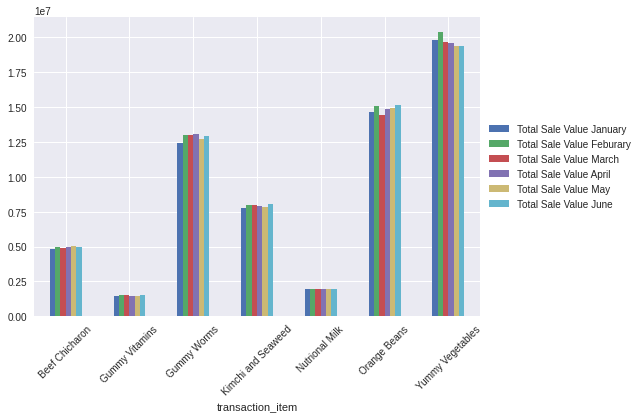

In [ ]:
saleValue.plot(y=["Total Sale Value January","Total Sale Value Feburary","Total Sale Value March","Total Sale Value April","Total Sale Value May","Total Sale Value June"], kind="bar",rot=45)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
plt.show

## Now we need Customers Who are repeaters, inactive or are engaged

In [ ]:
# we will start fresh
file = open('data-sample.json')
data = json.load(file)

# make this data a pandas dataframe
df = pd.DataFrame(data)
df['month'] = pd.DatetimeIndex(df['transaction_date']).month

In [ ]:
# Source: taken from stackOverflow
# https://stackoverflow.com/questions/50765199/i-need-to-make-a-truth-table-from-pandas-dataframe-based-on-values-on-a-column

i, r = pd.factorize(df.name)
j, c = pd.factorize(df.month)
b = np.zeros((r.size, c.size), int)
b[i, j] = 1

temp = pd.DataFrame(b, r, c)
# temp is customer bougth something in a month(column) or not 1 if yes 0 if not
temp

,1,2,3,4,5,6
Jennifer Campbell,1,1,1,0,0,1
Melissa Kim,1,1,1,1,1,0
Kristen Cooper,1,1,1,1,1,0
Alexander Davis,1,1,1,1,1,1
Michael Lowe,1,1,1,1,1,1
...,...,...,...,...,...,...
Patricia Carter,0,0,0,0,1,1
Ryan Stevens,0,0,0,0,1,1
Sonia Jones,0,0,0,0,1,0
Sue Douglas,0,0,0,0,0,1


In [ ]:
# now make sum of each columns as sum to be used
sum1 = temp[[1]].sum(axis=1)
sum2 = temp[[1,2]].sum(axis=1)
sum3 = temp[[1,2,3]].sum(axis=1)
sum4 = temp[[1,2,3,4]].sum(axis=1)
sum5 = temp[[1,2,3,4,5]].sum(axis=1)
sum6 = temp[[1,2,3,4,5,6]].sum(axis=1)

## Repeating Customers

In [ ]:
# here the sum of each month should be 2
# because if customer came in 1 month then the second his values should be 1 in both which add upto 2
repeaters2 = temp[temp[[1,2]].sum(axis=1) == 2]
repeaters3 = temp[temp[[2,3]].sum(axis=1) == 2]
repeaters4 = temp[temp[[3,4]].sum(axis=1) == 2]
repeaters5 = temp[temp[[4,5]].sum(axis=1) == 2]
repeaters6 = temp[temp[[5,6]].sum(axis=1) == 2]

## Inactive Customers

In [ ]:
# here the values should be 0 which means the customer is inactive
inactive2 = (temp[sum2 != 0] [temp[sum2 != 0][2]==0])
inactive3 = (temp[sum3 != 0] [temp[sum3 != 0][3]==0])
inactive4 = (temp[sum4 != 0] [temp[sum4 != 0][4]==0])
inactive5 = (temp[sum5 != 0] [temp[sum5 != 0][5]==0])
inactive6 = (temp[sum6 != 0] [temp[sum6 != 0][6]==0])

## Engaged Customers

In [ ]:
# here the values should be alternate for a engaged customer
engaged1 = temp[sum1 == 1]
engaged2 = temp[sum2 == 2]
engaged3 = temp[sum3 == 3]
engaged4 = temp[sum4 == 4]
engaged5 = temp[sum5 == 5]
engaged6 = temp[sum6 == 6]

In [ ]:
table = pd.DataFrame(
    {'January': [0,0,len(engaged1)],
     'Feburary': [len(repeaters2),len(inactive2),len(engaged2)],
     'March': [len(repeaters3),len(inactive3),len(engaged3)],
     'April': [len(repeaters4),len(inactive4),len(engaged4)],
     'May': [len(repeaters5),len(inactive5),len(engaged5)],
     'June': [len(repeaters6),len(inactive6),len(engaged6)],
    }, index = pd.Index(['Repeaters','Inactive','Engaged']))

tableData = table.rename_axis('Category')
tableData

,January,Feburary,March,April,May,June
Category,,,,,,
Repeaters,0,5172,5216,5154,5110,5193
Inactive,0,1416,1747,1909,1917,1835
Engaged,6588,5172,4126,3289,2667,2190


## Graph of Customer categories

<function matplotlib.pyplot.show>

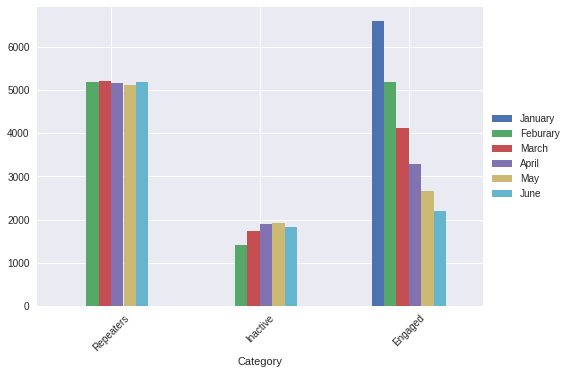

In [ ]:
tableData.plot(y=["January", "Feburary", "March", "April", "May", "June"], kind = "bar", rot = 45)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show